In [1]:
import os
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

c:\masterplanning\env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\skitl\AppData\Local\Temp\ipykernel_19516\1277540987.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are 

In [2]:
from masterplan_tools.method.blocks import CutParameters

city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet")).to_crs(local_crs)
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet")).to_crs(local_crs)
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet")).to_crs(local_crs)
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet")).to_crs(local_crs)

#basically we need just these 4 geometries to cut some blocks
cut_params = CutParameters(
  city=city_geometry,
  water=water_geometry,
  roads=roads_geometry,
  railways=railways_geometry
)

c:\masterplanning\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from masterplan_tools.method.blocks import LandUseParameters

no_development = gpd.read_file(os.path.join(example_data_path, "no_development_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
no_development = no_development[no_development['RAYON']=='Василеостровский']
landuse = gpd.read_file(os.path.join(example_data_path, "landuse_zone_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
buildings_geom = gpd.read_file(os.path.join(example_data_path, "buildings_blocks.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)

#but to improve our method we should use LU filtering
#if we don't set landuse parameters, no LU filtering will be applied to the blocks 
#(which can be ok if you need so)
lu_params = LandUseParameters(
  no_development=no_development,
  landuse=landuse,
  buildings=buildings_geom #not required actually, but is used to divide blocks by clusters
)

In [4]:
from masterplan_tools.method import BlocksCutter

blocks = BlocksCutter(
  cut_parameters=cut_params, 
  lu_parameters=lu_params,
).get_blocks()

c:\masterplanning\env\lib\site-packages\geopandas\geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
100%|██████████| 1/1 [00:00<00:00, 27.75it/s]
1416it [00:00, 2527.63it/s]


In [5]:
blocks.to_gdf()

,geometry,id,landuse
0,"POLYGON ((344943.719 6647610.514, 344959.205 6...",0,buildings
1,"POLYGON ((344968.687 6647544.000, 344971.625 6...",1,buildings
2,"POLYGON ((344929.592 6647257.521, 344931.964 6...",2,buildings
3,"POLYGON ((344840.676 6647432.974, 344853.943 6...",3,buildings
4,"POLYGON ((344856.398 6647391.171, 344900.097 6...",4,buildings
...,...,...,...
1355,"POLYGON ((346243.206 6647701.284, 346243.206 6...",1355,selected_area
1356,"POLYGON ((347483.986 6647345.029, 347483.627 6...",1356,selected_area
1357,"POLYGON ((347463.977 6647381.345, 347456.841 6...",1357,selected_area
1358,"POLYGON ((344028.826 6648834.242, 344112.884 6...",1358,no_dev_area


There are three landuse tags in the blocks gdf:
1. 'no_dev_area' -- according to th no_debelopment gdf and cutoff without any buildings or specified / selected landuse types;
2. 'selected_area' -- according to the landuse gdf. We separate theese polygons since they have specified landuse types;
3. 'buildings' -- there are polygons that have buildings landuse type. 

In further calculations we will use the in the following steps:
- Only 'buildings' -- to find clusters of buildings in big polygons;
- All of them while calculating the accessibility times among city blocks;
- All of them except 'no_dev_area' while optimizing the development of new facilities.

<Axes: >

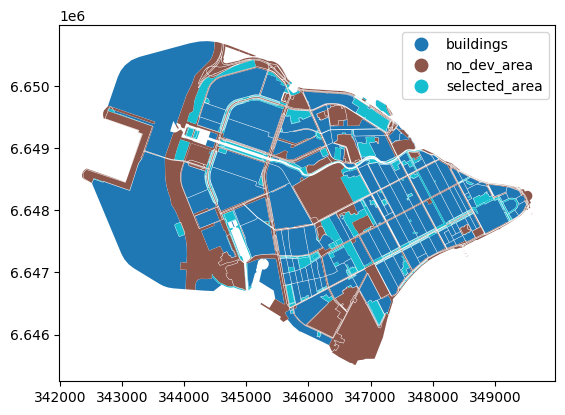

In [6]:
blocks.to_gdf().plot(column='landuse', legend=True)

In [7]:
blocks.to_gdf().to_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet"))